# Hack the Markets - prediction

In [259]:
#data analysis
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statistics import mean
from statistics import *

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as fplt

#preprocessing
from sklearn.preprocessing import StandardScaler
from numpy import asarray

#train test
from sklearn.model_selection import train_test_split

#classification
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#scores
from sklearn.metrics import f1_score
from sklearn import metrics

#search best parameters
from sklearn.model_selection import GridSearchCV
from sklearn import tree

#validation
from sklearn.model_selection import StratifiedKFold

## Dataset preprocessing

In [62]:
df = pd.read_csv('train.csv')
df.head(10)

,Date,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility,target
0,2000-01-03,0.6281,0.63300,0.6235,0.6272,NaN,NaN,NaN,NaN,0
1,2000-01-10,0.6271,0.62900,0.6181,0.6197,NaN,NaN,NaN,NaN,0
2,2000-01-17,0.6200,0.62250,0.6072,0.6090,NaN,NaN,NaN,NaN,1
3,2000-01-24,0.6091,0.61271,0.5990,0.6027,NaN,NaN,NaN,NaN,1
4,2000-01-31,0.6021,0.62670,0.5980,0.6158,NaN,NaN,NaN,NaN,0
5,2000-02-07,0.6166,0.62090,0.6102,0.6192,NaN,NaN,NaN,NaN,0
6,2000-02-14,0.6192,0.62320,0.6117,0.6157,NaN,NaN,NaN,NaN,1
7,2000-02-21,0.6161,0.62650,0.6100,0.6114,NaN,NaN,NaN,NaN,1
8,2000-02-28,0.6117,0.61740,0.5929,0.6060,NaN,NaN,NaN,NaN,0
9,2000-03-06,0.6059,0.61320,0.6020,0.6102,NaN,NaN,NaN,NaN,0


In [63]:
#nan values?
df.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close          0
rsi           14
ema_fast      13
ema_slow      41
volatility    14
target         0
dtype: int64

In [64]:
#select only rows with values, nan out
data = df.iloc[41:]
data.head(10)

,Date,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility,target
41,2000-10-16,0.5882,0.5923,0.5775,0.5785,30.382367,0.602323,0.610376,2.605170,1
42,2000-10-23,0.5786,0.5876,0.5731,0.5784,30.343134,0.599133,0.608889,2.598570,1
43,2000-10-30,0.5783,0.6044,0.5771,0.5980,45.262621,0.598982,0.608382,2.659958,1
44,2000-11-06,0.5982,0.6079,0.5940,0.6040,48.872746,0.599651,0.608179,2.609805,1
45,2000-11-13,0.6042,0.6052,0.5941,0.5966,44.936330,0.599244,0.607640,2.586345,1
46,2000-11-20,0.5967,0.6024,0.5930,0.5989,46.381859,0.599198,0.607234,2.504494,1
47,2000-11-27,0.5988,0.6143,0.5952,0.6100,52.819203,0.600639,0.607362,2.506936,1
48,2000-12-04,0.6099,0.6208,0.6079,0.6097,52.635272,0.601847,0.607471,2.480143,1
49,2000-12-11,0.6098,0.6179,0.6000,0.6070,50.916767,0.602534,0.607449,2.523872,1
50,2000-12-18,0.6068,0.6263,0.6050,0.6245,60.026493,0.605463,0.608242,2.521545,1


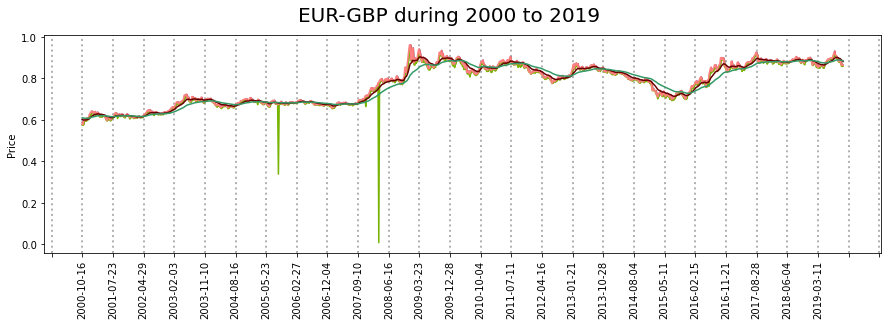

In [65]:
fig, ax = plt.subplots(figsize =(15, 4))

sns.lineplot(x=data['Date'],y=data['Open'],color='#3274A1')
sns.lineplot(x=data['Date'],y=data['Open'],color='#ff6666')
sns.lineplot(x=data['Date'],y=data['Low'],color='#77b300')
sns.lineplot(x=data['Date'],y=data['Close'],color='#ff8080')
sns.lineplot(x=data['Date'],y=data['ema_fast'],color='#660000')
sns.lineplot(x=data['Date'],y=data['ema_slow'],color='#339966')

plt.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(35))
plt.grid(axis="x", color="black", alpha=.3, linewidth=2, linestyle=":")
plt.xlabel("")
plt.ylabel("Price")
plt.suptitle("EUR-GBP during 2000 to 2019",fontsize=20)
plt.show()

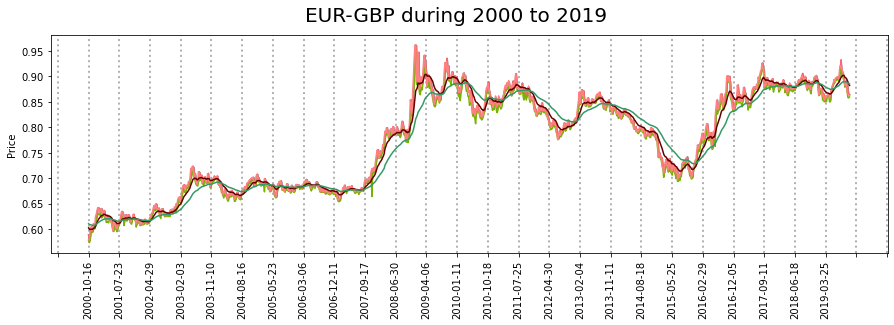

In [66]:
#delete two outliers below 0.4
data = data[data['Low'] > 0.4]

fig, ax = plt.subplots(figsize =(15, 4))

sns.lineplot(x=data['Date'],y=data['Open'],color='#3274A1')
sns.lineplot(x=data['Date'],y=data['Open'],color='#ff6666')
sns.lineplot(x=data['Date'],y=data['Low'],color='#77b300')
sns.lineplot(x=data['Date'],y=data['Close'],color='#ff8080')
sns.lineplot(x=data['Date'],y=data['ema_fast'],color='#660000')
sns.lineplot(x=data['Date'],y=data['ema_slow'],color='#339966')

plt.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(35))
plt.grid(axis="x", color="black", alpha=.3, linewidth=2, linestyle=":")
plt.xlabel("")
plt.ylabel("Price")
plt.suptitle("EUR-GBP during 2000 to 2019",fontsize=20)
plt.show()

In [22]:
data.to_csv('train_clean.csv')

## XGBoost model

In [30]:
data = pd.read_csv('train_clean.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data = data.set_index('Date')
data.head(5)

,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility,target
Date,,,,,,,,,
2000-10-16,0.5882,0.5923,0.5775,0.5785,30.382367,0.602323,0.610376,2.605170,1
2000-10-23,0.5786,0.5876,0.5731,0.5784,30.343134,0.599133,0.608889,2.598570,1
2000-10-30,0.5783,0.6044,0.5771,0.5980,45.262621,0.598982,0.608382,2.659958,1
2000-11-06,0.5982,0.6079,0.5940,0.6040,48.872746,0.599651,0.608179,2.609805,1
2000-11-13,0.6042,0.6052,0.5941,0.5966,44.936330,0.599244,0.607640,2.586345,1


In [32]:
group1 = data[data['target'] == 1]
group2 = data[data['target'] == 0]
x = round(len(group1) / len(data) * 100)
y = round(len(group2) / len(data) * 100)
print('Percentage of status 1 is',x,'%')
print('Percentage of status 0 is',y,'%')

Percentage of status 1 is 51 %
Percentage of status 0 is 49 %


In [33]:
data.count()

Open          992
High          992
Low           992
Close         992
rsi           992
ema_fast      992
ema_slow      992
volatility    992
target        992
dtype: int64

In [36]:
#divide target and features for prediction
X = data.drop('target',axis=1)
y = data['target']

In [37]:
X.head()

,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility
Date,,,,,,,,
2000-10-16,0.5882,0.5923,0.5775,0.5785,30.382367,0.602323,0.610376,2.605170
2000-10-23,0.5786,0.5876,0.5731,0.5784,30.343134,0.599133,0.608889,2.598570
2000-10-30,0.5783,0.6044,0.5771,0.5980,45.262621,0.598982,0.608382,2.659958
2000-11-06,0.5982,0.6079,0.5940,0.6040,48.872746,0.599651,0.608179,2.609805
2000-11-13,0.6042,0.6052,0.5941,0.5966,44.936330,0.599244,0.607640,2.586345


In [41]:
#standartization
scaler = StandardScaler()
data = asarray(X)
X = pd.DataFrame(scaler.fit_transform(data),columns=X.columns)

In [42]:
X.head()

,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility
0,-1.926765,-1.762315,-1.998671,-2.033284,-2.050747,-1.779733,-1.684122,0.319871
1,-2.026902,-1.806078,-2.045238,-2.034328,-2.054572,-1.813286,-1.700041,0.315411
2,-2.030031,-1.649650,-2.002904,-1.829749,-0.600078,-1.814875,-1.705463,0.356896
3,-1.822457,-1.617061,-1.824044,-1.767123,-0.248129,-1.807837,-1.707645,0.323003
4,-1.759871,-1.642201,-1.822986,-1.844362,-0.631888,-1.812117,-1.713409,0.307149


In [43]:
#Train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
#XGBoost - GridSearch process
parameters = { 'max_depth': [2,5,10],
           'learning_rate': [0.1, 0.2],
           'n_estimators': [10,50,100],
           'colsample_bytree': [0.2, 0.3],
           'objective':['reg:squarederror', 'reg:logistic']}

clf = GridSearchCV(xgb.XGBClassifier(), parameters, n_jobs=4)
clf.fit(X_train, y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.6729329579814409 {'colsample_bytree': 0.3, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'objective': 'reg:logistic'}


In [80]:
#Cross Validation - XGBoost
#Create classifier object - using parameters defined from GridSearch
model1 = xgb.XGBClassifier(colsample_bytree=0.3,learning_rate=0.2,max_depth=10,n_estimators=100,objective='reg:logistic')

#Stratified k-Fold
skf = StratifiedKFold(n_splits=10,shuffle=True, random_state=1)
model1_accu = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model1.fit(x_train_fold, y_train_fold)
    model1_accu.append(model1.score(x_test_fold, y_test_fold))

print('List of possible accuracy:', model1_accu)
print('Maximum Accuracy That can be obtained from this model is:',
      max(model1_accu)*100, '%')
print('Minimum Accuracy:',
      min(model1_accu)*100, '%')
print('Overall Accuracy:',
      mean(model1_accu)*100, '%')
print('Standard Deviation is:', stdev(model1_accu))

List of possible accuracy: [0.72, 0.75, 0.7070707070707071, 0.7373737373737373, 0.7373737373737373, 0.7070707070707071, 0.6767676767676768, 0.6666666666666666, 0.7272727272727273, 0.6060606060606061]
Maximum Accuracy That can be obtained from this model is: 75.0 %
Minimum Accuracy: 60.60606060606061 %
Overall Accuracy: 70.35656565656565 %
Standard Deviation is: 0.04331500453468116


In [81]:
predictions = model1.predict(X_test)
y_pred1 = [round(value) for value in predictions]

In [82]:
f1 = f1_score(y_test, y_pred1)
print('F1 score XGBoost model:',f1)

F1 score XGBoost model: 0.9515151515151515


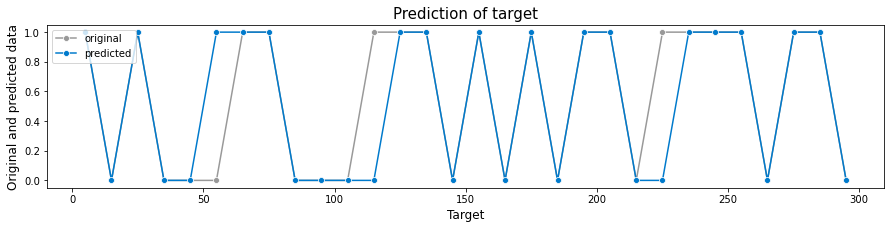

In [248]:
#compare values from test and predict for the model
y1 = y_test.reset_index(drop=True)
y2 = pd.Series(y_pred1)

#for simple visualization let's take sistematic sample
step_num = 10
def randomNum():
    num = np.random.randint(1, 10)
    return num
num = randomNum()

simple_df1 = y1[num:len(y1):step_num]
simple_df2 = y2[num:len(y2):step_num]

plt.figure(figsize =(15, 3))

sns.lineplot(data=simple_df1, color='#999999',label='original', marker='o')
sns.lineplot(data=simple_df2, color='#007acc',label='predicted', marker='o')
plt.title("Prediction of target",fontsize=15)
plt.xlabel("Target",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)
plt.legend(loc="upper left")
plt.show()

## Decision tree

In [249]:
data = pd.read_csv('train_clean.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data = data.set_index('Date')
data.head(5)

,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility,target
Date,,,,,,,,,
2000-10-16,0.5882,0.5923,0.5775,0.5785,30.382367,0.602323,0.610376,2.605170,1
2000-10-23,0.5786,0.5876,0.5731,0.5784,30.343134,0.599133,0.608889,2.598570,1
2000-10-30,0.5783,0.6044,0.5771,0.5980,45.262621,0.598982,0.608382,2.659958,1
2000-11-06,0.5982,0.6079,0.5940,0.6040,48.872746,0.599651,0.608179,2.609805,1
2000-11-13,0.6042,0.6052,0.5941,0.5966,44.936330,0.599244,0.607640,2.586345,1


In [260]:
#divide target and features for prediction
X = data.drop('target',axis=1)
y = data['target']

In [261]:
X.head()

,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility
Date,,,,,,,,
2000-10-16,0.5882,0.5923,0.5775,0.5785,30.382367,0.602323,0.610376,2.605170
2000-10-23,0.5786,0.5876,0.5731,0.5784,30.343134,0.599133,0.608889,2.598570
2000-10-30,0.5783,0.6044,0.5771,0.5980,45.262621,0.598982,0.608382,2.659958
2000-11-06,0.5982,0.6079,0.5940,0.6040,48.872746,0.599651,0.608179,2.609805
2000-11-13,0.6042,0.6052,0.5941,0.5966,44.936330,0.599244,0.607640,2.586345


In [262]:
#standartization
scaler = StandardScaler()
data = asarray(X)
X = pd.DataFrame(scaler.fit_transform(data),columns=X.columns)

In [263]:
X.head()

,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility
0,-1.926765,-1.762315,-1.998671,-2.033284,-2.050747,-1.779733,-1.684122,0.319871
1,-2.026902,-1.806078,-2.045238,-2.034328,-2.054572,-1.813286,-1.700041,0.315411
2,-2.030031,-1.649650,-2.002904,-1.829749,-0.600078,-1.814875,-1.705463,0.356896
3,-1.822457,-1.617061,-1.824044,-1.767123,-0.248129,-1.807837,-1.707645,0.323003
4,-1.759871,-1.642201,-1.822986,-1.844362,-0.631888,-1.812117,-1.713409,0.307149


In [264]:
#Train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [265]:
#Decision Tree Classifier - GridSearch process
parameters = {'max_depth':range(3,20),
             'criterion':['gini', 'entropy'],
             'splitter':['best', 'random']}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, cv=10)
clf.fit(X_train, y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.6771428571428572 {'criterion': 'gini', 'max_depth': 18, 'splitter': 'best'}


In [267]:
#Cross Validation - Decision Tree
#Create classifier object - using parameters defined from GridSearch
model2 = DecisionTreeClassifier(criterion='gini', max_depth=18, splitter='best', random_state=42)

#Stratified k-Fold - large imbalance of the target value in the dataset
skf = StratifiedKFold(n_splits=10,shuffle=True, random_state=1)
model2_accu = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model2.fit(x_train_fold, y_train_fold)
    model2_accu.append(model2.score(x_test_fold, y_test_fold))

print('List of possible accuracy:', model1_accu)
print('Maximum Accuracy That can be obtained from this model is:',
      max(model2_accu)*100, '%')
print('Minimum Accuracy:',
      min(model2_accu)*100, '%')
print('Overall Accuracy:',
      mean(model2_accu)*100, '%')
print('Standard Deviation is:', stdev(model2_accu))

List of possible accuracy: [0.72, 0.75, 0.7070707070707071, 0.7373737373737373, 0.7373737373737373, 0.7070707070707071, 0.6767676767676768, 0.6666666666666666, 0.7272727272727273, 0.6060606060606061]
Maximum Accuracy That can be obtained from this model is: 72.0 %
Minimum Accuracy: 62.62626262626263 %
Overall Accuracy: 67.43636363636364 %
Standard Deviation is: 0.029642551513486163


In [268]:
predictions = model2.predict(X_test)
y_pred2 = [round(value) for value in predictions]

In [270]:
f2 = f1_score(y_test, y_pred2)
print('F1 score Decision Tree model:',f2)

F1 score Decision Tree model: 0.868421052631579


F1 score is a bit lower than the F1 score from XGBoost model. For that reason the first model - XGBoost has been used for the final prediction.

## Prediction

In [85]:
#import variables for prediction
X_test_df = pd.read_csv("test_x.csv")
X_test_df.head()

,Date,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility
0,2019-11-04,0.86290,0.86561,0.85930,0.86206,34.917807,0.879483,0.883823,1.630470
1,2019-11-11,0.86133,0.86192,0.85445,0.85610,32.209828,0.876366,0.882534,1.588042
2,2019-11-18,0.85552,0.86043,0.85241,0.85781,33.796239,0.873892,0.881384,1.538452
3,2019-11-25,0.85750,0.85840,0.85000,0.85130,30.837556,0.870879,0.879985,1.509968
4,2019-12-02,0.85328,0.85730,0.84138,0.84138,26.963846,0.866946,0.878189,1.553796


In [86]:
X_test_df.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
rsi           0
ema_fast      0
ema_slow      0
volatility    0
dtype: int64

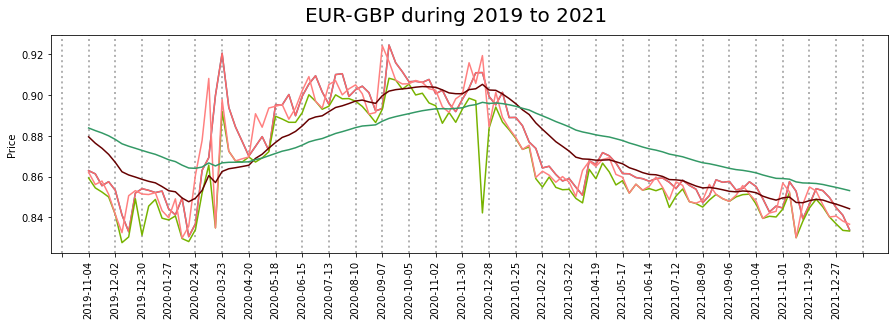

In [87]:
fig, ax = plt.subplots(figsize =(15, 4))

sns.lineplot(x=X_test_df['Date'],y=X_test_df['Open'],color='#3274A1')
sns.lineplot(x=X_test_df['Date'],y=X_test_df['Open'],color='#ff6666')
sns.lineplot(x=X_test_df['Date'],y=X_test_df['Low'],color='#77b300')
sns.lineplot(x=X_test_df['Date'],y=X_test_df['Close'],color='#ff8080')
sns.lineplot(x=X_test_df['Date'],y=X_test_df['ema_fast'],color='#660000')
sns.lineplot(x=X_test_df['Date'],y=X_test_df['ema_slow'],color='#339966')

plt.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(35))
plt.grid(axis="x", color="black", alpha=.3, linewidth=2, linestyle=":")
plt.xlabel("")
plt.ylabel("Price")
plt.suptitle("EUR-GBP during 2019 to 2021",fontsize=20)
plt.show()

In [88]:
X_test_df = X_test_df.set_index('Date')

In [89]:
#standartization
scaler = StandardScaler()
data = asarray(X_test_df)
X_test_df = pd.DataFrame(scaler.fit_transform(data),columns=X_test_df.columns)

In [90]:
X_test_df.head()

,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility
0,-0.401182,-0.526416,-0.210065,-0.330740,-1.368442,0.365157,0.661096,-0.504313
1,-0.466643,-0.669346,-0.422202,-0.572226,-1.696667,0.205153,0.553718,-0.586360
2,-0.708891,-0.727060,-0.511431,-0.502940,-1.504384,0.078184,0.457957,-0.682256
3,-0.626335,-0.805691,-0.616844,-0.766710,-1.862996,-0.076402,0.341436,-0.737340
4,-0.802288,-0.848298,-0.993880,-1.168645,-2.332515,-0.278255,0.191912,-0.652585


In [238]:
#final prediction for provided dataset of 30 values
prediction = model1.predict(X_test_df)
prediction

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1])

In [239]:
prediction = pd.DataFrame(data = prediction,columns=['target'])
prediction.to_csv('final_prediction.csv',index=False)

In [240]:
prediction

,target
0,0
1,1
2,1
3,0
4,0
...,...
110,1
111,1
112,1
113,1


## Comparing prediction with calculated target values

In [229]:
#import variables for prediction
data_test = pd.read_csv("test_x.csv")
data_test.head(5)

,Date,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility
0,2019-11-04,0.86290,0.86561,0.85930,0.86206,34.917807,0.879483,0.883823,1.630470
1,2019-11-11,0.86133,0.86192,0.85445,0.85610,32.209828,0.876366,0.882534,1.588042
2,2019-11-18,0.85552,0.86043,0.85241,0.85781,33.796239,0.873892,0.881384,1.538452
3,2019-11-25,0.85750,0.85840,0.85000,0.85130,30.837556,0.870879,0.879985,1.509968
4,2019-12-02,0.85328,0.85730,0.84138,0.84138,26.963846,0.866946,0.878189,1.553796


In [230]:
#create column target
data_test["target"] = np.nan
data_test.head(5)

,Date,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility,target
0,2019-11-04,0.86290,0.86561,0.85930,0.86206,34.917807,0.879483,0.883823,1.630470,NaN
1,2019-11-11,0.86133,0.86192,0.85445,0.85610,32.209828,0.876366,0.882534,1.588042,NaN
2,2019-11-18,0.85552,0.86043,0.85241,0.85781,33.796239,0.873892,0.881384,1.538452,NaN
3,2019-11-25,0.85750,0.85840,0.85000,0.85130,30.837556,0.870879,0.879985,1.509968,NaN
4,2019-12-02,0.85328,0.85730,0.84138,0.84138,26.963846,0.866946,0.878189,1.553796,NaN


In [231]:
#how many rows are there
data_test['Close'].count()

115

In [232]:
# set value 0 or 1 based on the condition
for i in range(0, 111):
    j = data_test['Close'].iloc[i]
    k = data_test['Close'].iloc[i+4]
    if j < k:
        data_test.at[i, 'target'] = 1
    else:
        data_test.at[i, 'target'] = 0
         
data_test.head(3)

,Date,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility,target
0,2019-11-04,0.86290,0.86561,0.85930,0.86206,34.917807,0.879483,0.883823,1.630470,0.0
1,2019-11-11,0.86133,0.86192,0.85445,0.85610,32.209828,0.876366,0.882534,1.588042,0.0
2,2019-11-18,0.85552,0.86043,0.85241,0.85781,33.796239,0.873892,0.881384,1.538452,0.0


It is considered that the predicted value is calculated as a difference between the closing value from one week and the closing value of the next month same week. Normally one month has 4 weeks so number 4 was used to iterate through the data. On the other hand, not all months has 4 weeks so the calculated target value can be different in same cases.

In [234]:
#fill last values as 1
data_test['target'] = data_test['target'].fillna(1)

In [235]:
len(data_test['target'])

115

In [241]:
len(prediction['target'])

115

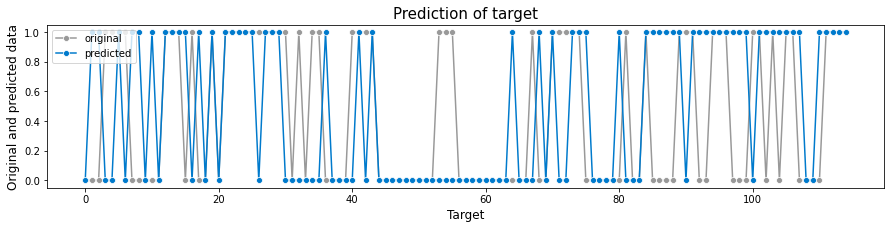

In [247]:
#plot how the predictive model is going
plt.figure(figsize =(15, 3))

sns.lineplot(data=data_test['target'], color='#999999',label='original', marker='o')
sns.lineplot(data=prediction['target'], color='#007acc',label='predicted', marker='o')
plt.title("Prediction of target",fontsize=15)
plt.xlabel("Target",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)
plt.legend(loc="upper left")
plt.show()

The diagram is showing the predicted values and the real values. The model is quite accurate but I could be improved by inserting more related data. Por exemple the GDP of UK and EU, the interest rates, the amount of long-term debt.